In [1]:
from scipy import signal as sg
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import glob

In [2]:
#Metti nella stessa cartella di questo notebook il file wav da analizzare
files = glob.glob("*.wav")
file = files[0]
print(file)

20211121_050319_192.wav


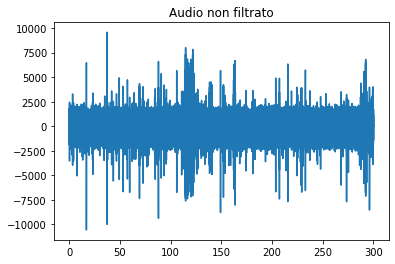

In [3]:
# Importazione file audio wavù
sr,wav = wavfile.read(file)
N = wav.shape[0]
t = np.arange(N) / sr
plt.plot(t, wav)
plt.title("Audio non filtrato")
plt.show()

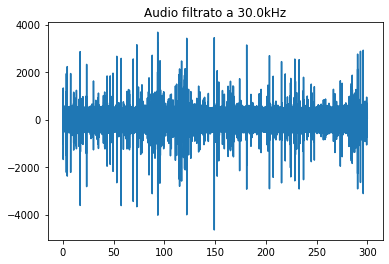

In [4]:
# Filtraggio passa alto
low_band = 30e3
filter = sg.butter(4, low_band, btype='highpass', analog=False, output='sos', fs=sr)
wav = sg.sosfilt(filter, wav)
plt.plot(t, wav)
plt.title(f"Audio filtrato a {low_band//1e3}kHz")
plt.show()

In [5]:
chunk_length = 1  #sec chunk
chunk_size = int(chunk_length*sr)   #numero campioni chunk
chunk_step = chunk_size#//2  #decommentare per avere i chunk sovrapposti (overlappati) di mezzo chunk (se ne otterranno il doppio)
wav_chunks = []
time_chunks = []
for i in range(0, N, chunk_step):
    time_chunks.append(t[i: i+chunk_size])
    wav_chunks.append(wav[i: i+chunk_size])
print(len(wav_chunks))

301


In [38]:
# Di seguito indici di chunk interessanti, decommentare quello da usare

#n = 120    # click ben definiti
#n = 164     # singolo click(?) isolato
#n = 3*60+55    # assenza di click (solo rumore)
#n = 4*60+44    # tanti click stretti
n = 283
time_chunk = time_chunks[n]
wav_chunk = wav_chunks[n]

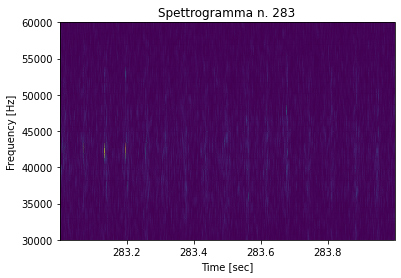

In [39]:
freqs, time, Sxx = sg.spectrogram(wav_chunks[n], sr)
time_plot = time + n
plt.pcolormesh(time_plot, freqs, Sxx, shading="gouraud")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title(f"Spettrogramma n. {n}")
plt.ylim([low_band, 60e3])
plt.show()

In [40]:
ss = wav_chunk - np.mean(wav_chunk)
nn = np.sqrt(np.mean(np.square(ss)))
snr = np.abs(ss) / nn

threshold = 4.5
distance = 50e-3*sr

peaks, props = sg.find_peaks(snr, height=threshold, distance=distance)

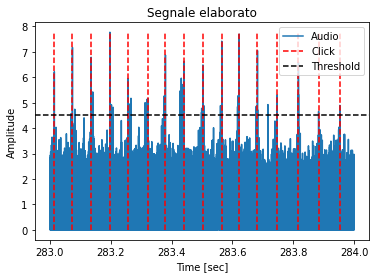

In [41]:
plt.plot(time_chunk, snr)
plt.vlines(time_chunks[n][peaks], 0, np.max(snr), colors="red", linestyles="dashed")
plt.axhline(threshold, color="black", linestyle="dashed")
plt.title("Segnale elaborato")
plt.legend(["Audio", "Click", "Threshold"])
plt.xlabel("Time [sec]")
plt.ylabel("Amplitude")
plt.show()


In [42]:
peaks_true = False
if peaks.shape[0]>=5:
    print("DELFINO SI")
    peaks_true = True
else:
    print("DELFINO NO")

DELFINO SI


# Trasformata di Hilbert

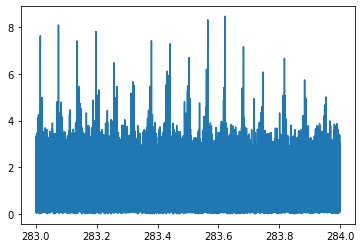

In [43]:
env = np.abs(sg.hilbert(ss)) / nn
plt.plot(time_chunk, env)
plt.show()

# Analisi statistica dei picchi

In [44]:
peaks_dist = np.diff(peaks)
peaks_len = peaks.shape[0]
std = np.std(peaks_dist)
mean = np.mean(peaks_dist)
print(peaks_dist)
print("N. picchi = ", peaks_len)
print("Media distanza picchi = ", mean)
print("Dev. std. distanza picchi = ",std)
print("Varianza distanze picchi = ", std*std)


[11434 11759 11862 11446 12617 10970 11848 11806 11865 10985 11553 12372
 13469 12733 13399]
N. picchi =  16
Media distanza picchi =  12007.866666666667
Dev. std. distanza picchi =  741.3902136452092
Varianza distanze picchi =  549659.4488888889


In [45]:
chi = std * std * (peaks_len - 1) / (4000*4000)
chi


0.5153057333333334